In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
## get mappings of sid (a random number) to systems (adslabs) that are in the OC20 dataset 
with open("../oc20_data_mapping.pkl", "rb") as input_file:
    mappings = pickle.load(input_file)
## get mappings of sid (a random number) to systems (adslabs) that are in the OC20 dataset 
with open("../oc20_ref.pkl", "rb") as input_file:
    ref_mappings = pickle.load(input_file)

In [4]:
df_val_id = pd.read_csv("../val_sets_with_anomalies/val_id_30k_anomalies.csv", index_col=0) 
df_ood_cat = pd.read_csv("../val_sets_with_anomalies/val_ood_cat_30k_anomalies.csv", index_col=0)
df_ood_ads = pd.read_csv("../val_sets_with_anomalies/val_ood_ads_30k_anomalies.csv", index_col=0)
df_ood_both = pd.read_csv("../val_sets_with_anomalies/val_ood_both_30k_anomalies.csv", index_col=0)

In [5]:
for df in [df_val_id,df_ood_cat,df_ood_ads,df_ood_both]:
    material_classes = []
    surfaces = []
    adsorbates = []
    for i in tqdm(df["sid"].values):
        material_classes.append(mappings[i]["class"])
        surfaces.append(mappings[i]["bulk_symbols"])
        adsorbates.append(mappings[i]["ads_symbols"])
    material_classes = np.array(material_classes)
    # add system information to the dataframe
    df["cat_class"] = material_classes
    df["bulk_symbols"] = surfaces
    df["ads_symbols"] = adsorbates

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:00<00:00, 680934.04it/s]


In [6]:
# goc linear referencing inference
inference_path = "/home/jovyan/shared-scratch/kabdelma/oc20_data_quality_project/s2ef_200k_experiment/remove_anomalies/"
pred_path = inference_path + "results/2024-03-07-18-03-44-goc_20_22_lin_ref_val_id/s2ef_predictions.npz"
val_id_predictions = np.load(pred_path)

In [7]:
pred_path = inference_path + "results/2024-03-07-18-16-32-goc_20_22_lin_ref_val_ood_cat/s2ef_predictions.npz"
val_ood_cat_predictions = np.load(pred_path)

In [8]:
pred_path = inference_path + "results/2024-03-07-18-10-08-goc_20_22_lin_ref_val_ood_ads/s2ef_predictions.npz"
val_ood_ads_predictions = np.load(pred_path)

In [9]:
pred_path = inference_path + "results/2024-03-07-18-22-56-goc_20_22_lin_ref_val_ood_both/s2ef_predictions.npz"
val_ood_both_predictions = np.load(pred_path)

In [10]:
val_id_preds_goc = []
for i in tqdm(range(len(df_val_id))):
    sid_fid = df_val_id.iloc[i]["sid"][6:] + "_" +  str(df_val_id.iloc[i]["fid"])
    val_id_preds_goc.append(val_id_predictions["energy"][np.where(val_id_predictions["ids"]==sid_fid)[0]][0])

100%|██████████| 30000/30000 [02:53<00:00, 173.22it/s]


In [11]:
val_ood_cat_preds_goc = []
for i in tqdm(range(len(df_ood_cat))):
    sid_fid = df_ood_cat.iloc[i]["sid"][6:] + "_" + str(df_ood_cat.iloc[i]["fid"])
    val_ood_cat_preds_goc.append(val_ood_cat_predictions["energy"][np.where(val_ood_cat_predictions["ids"]==sid_fid)[0]][0])

100%|██████████| 30000/30000 [02:53<00:00, 172.55it/s]


In [12]:
val_ood_ads_preds_goc = []
for i in tqdm(range(len(df_ood_ads))):
    sid_fid = df_ood_ads.iloc[i]["sid"][6:] + "_" + str(df_ood_ads.iloc[i]["fid"])
    val_ood_ads_preds_goc.append(val_ood_ads_predictions["energy"][np.where(val_ood_ads_predictions["ids"]==sid_fid)[0]][0])

100%|██████████| 30000/30000 [02:53<00:00, 172.71it/s]


In [13]:
val_ood_both_preds_goc = []
for i in tqdm(range(len(df_ood_both))):
    sid_fid = df_ood_both.iloc[i]["sid"][6:] + "_" + str(df_ood_both.iloc[i]["fid"])
    val_ood_both_preds_goc.append(val_ood_both_predictions["energy"][np.where(val_ood_both_predictions["ids"]==sid_fid)[0]][0])

100%|██████████| 30000/30000 [02:48<00:00, 178.43it/s]


In [14]:
total_energy_ref = []
for i in tqdm(range(len(df_val_id))):
    sid = df_val_id.iloc[i]["sid"]
    total_energy_ref.append(ref_mappings[sid])

100%|██████████| 30000/30000 [00:03<00:00, 9578.67it/s]


In [15]:
df_val_id["dft_total_energy"] = df_val_id["ref_energies"] + total_energy_ref
df_val_id["total_energy_pred"] = val_id_preds_goc

In [16]:
id_mae = np.mean(np.abs(df_val_id["dft_total_energy"] - df_val_id["total_energy_pred"]))

id_no_surf_anom_mae = np.mean(np.abs(df_val_id.query("surface_anomalies!=1")["dft_total_energy"] \
- df_val_id.query("surface_anomalies!=1")["total_energy_pred"]))

id_no_ads_anom_mae = np.mean(np.abs(df_val_id.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["dft_total_energy"] \
- df_val_id.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["total_energy_pred"]))

In [17]:
total_energy_ref_ood_ads = []
for i in tqdm(range(len(df_ood_ads))):
    sid = df_ood_ads.iloc[i]["sid"]
    total_energy_ref_ood_ads.append(ref_mappings[sid])

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:03<00:00, 9390.31it/s]


In [18]:
df_ood_ads["dft_total_energy"] = df_ood_ads["ref_energies"] + total_energy_ref_ood_ads
df_ood_ads["total_energy_pred"] = val_ood_ads_preds_goc

In [19]:
ood_ads_mae = np.mean(np.abs(df_ood_ads["dft_total_energy"] - df_ood_ads["total_energy_pred"]))

ood_ads_no_surf_anom_mae = np.mean(np.abs(df_ood_ads.query("surface_anomalies!=1")["dft_total_energy"] \
- df_ood_ads.query("surface_anomalies!=1")["total_energy_pred"]))

ood_ads_no_ads_anom_mae = np.mean(np.abs(df_ood_ads.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["dft_total_energy"] \
- df_ood_ads.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["total_energy_pred"]))

In [20]:
total_energy_ref_ood_cat = []
for i in tqdm(range(len(df_ood_cat))):
    sid = df_ood_cat.iloc[i]["sid"]
    total_energy_ref_ood_cat.append(ref_mappings[sid])

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:03<00:00, 9524.17it/s]


In [21]:
df_ood_cat["dft_total_energy"] = df_ood_cat["ref_energies"] + total_energy_ref_ood_cat
df_ood_cat["total_energy_pred"] = val_ood_cat_preds_goc

In [22]:
ood_cat_mae = np.mean(np.abs(df_ood_cat["dft_total_energy"] - df_ood_cat["total_energy_pred"]))

ood_cat_no_surf_anom_mae = np.mean(np.abs(df_ood_cat.query("surface_anomalies!=1")["dft_total_energy"] \
- df_ood_cat.query("surface_anomalies!=1")["total_energy_pred"]))

ood_cat_no_ads_anom_mae = np.mean(np.abs(df_ood_cat.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["dft_total_energy"] \
- df_ood_cat.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["total_energy_pred"]))

In [23]:
total_energy_ref_ood_both = []
for i in tqdm(range(len(df_ood_both))):
    sid = df_ood_both.iloc[i]["sid"]
    total_energy_ref_ood_both.append(ref_mappings[sid])

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:03<00:00, 9625.70it/s]


In [24]:
df_ood_both["dft_total_energy"] = df_ood_both["ref_energies"] + total_energy_ref_ood_both
df_ood_both["total_energy_pred"] = val_ood_both_preds_goc

In [25]:
ood_both_mae = np.mean(np.abs(df_ood_both["dft_total_energy"] - df_ood_both["total_energy_pred"]))

ood_both_no_surf_anom_mae = np.mean(np.abs(df_ood_both.query("surface_anomalies!=1")["dft_total_energy"] \
- df_ood_both.query("surface_anomalies!=1")["total_energy_pred"]))

ood_both_no_ads_anom_mae = np.mean(np.abs(df_ood_both.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["dft_total_energy"] \
- df_ood_both.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["total_energy_pred"]))

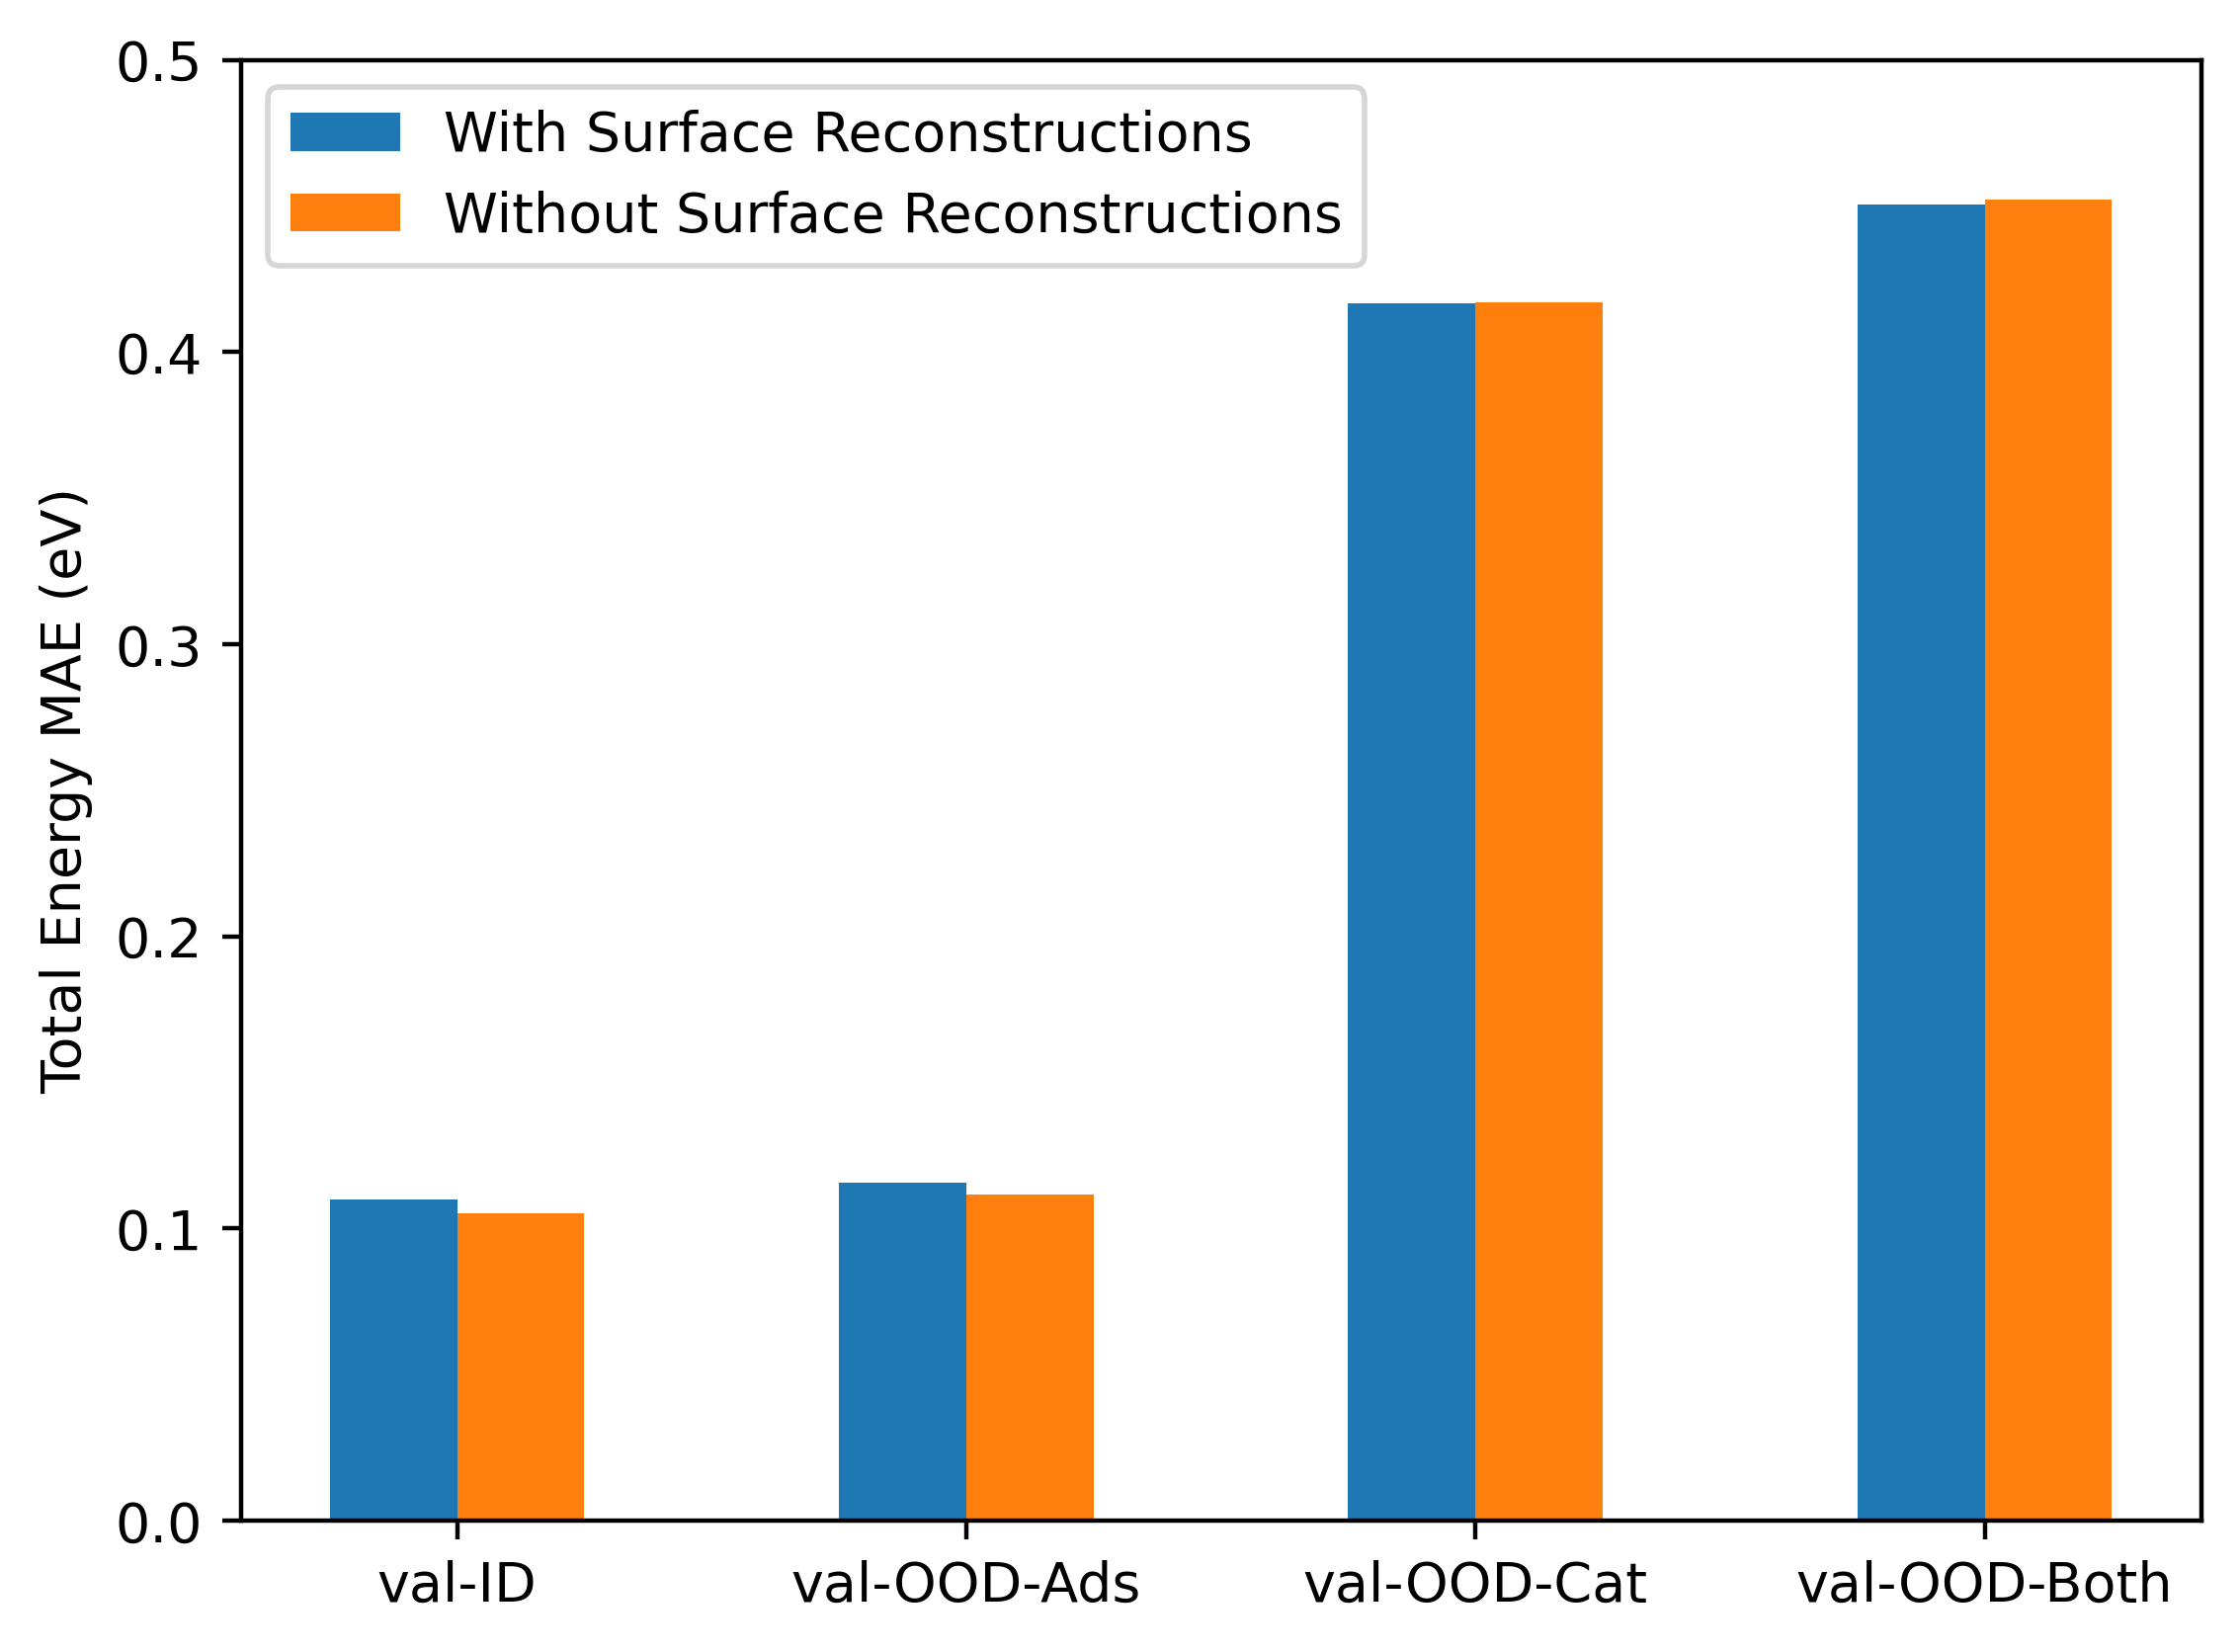

In [26]:
plt.figure(dpi=400)
val_sets = ["val-ID", "val-OOD-Ads", "val-OOD-Cat", "val-OOD-Both"]
original_maes = [id_mae, ood_ads_mae, ood_cat_mae, ood_both_mae]
surf_anom_maes = [id_no_surf_anom_mae, ood_ads_no_surf_anom_mae, ood_cat_no_surf_anom_mae, ood_both_no_surf_anom_mae]
ads_anom_maes = [id_no_ads_anom_mae, ood_ads_no_ads_anom_mae, ood_cat_no_ads_anom_mae, ood_both_no_ads_anom_mae]

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
x_range = np.arange(len(original_maes))
r1 = x_range - bar_width/2
r2 = x_range
r3 = x_range + bar_width/2

# Plotting the bars
plt.bar(r1, original_maes, width=bar_width, label='With Surface Reconstructions')
plt.bar(r3, surf_anom_maes, width=bar_width, label='Without Surface Reconstructions')
# plt.bar(r3, ads_anom_maes, width=bar_width, label='Without Adsorbate Anomalies')

# Customizing xticks
plt.xticks(x_range, val_sets)

# Adding labels and title
plt.ylabel("Total Energy MAE (eV)")

# Adding legend
plt.legend()
plt.ylim(0,0.5)

# Show plot
plt.show()

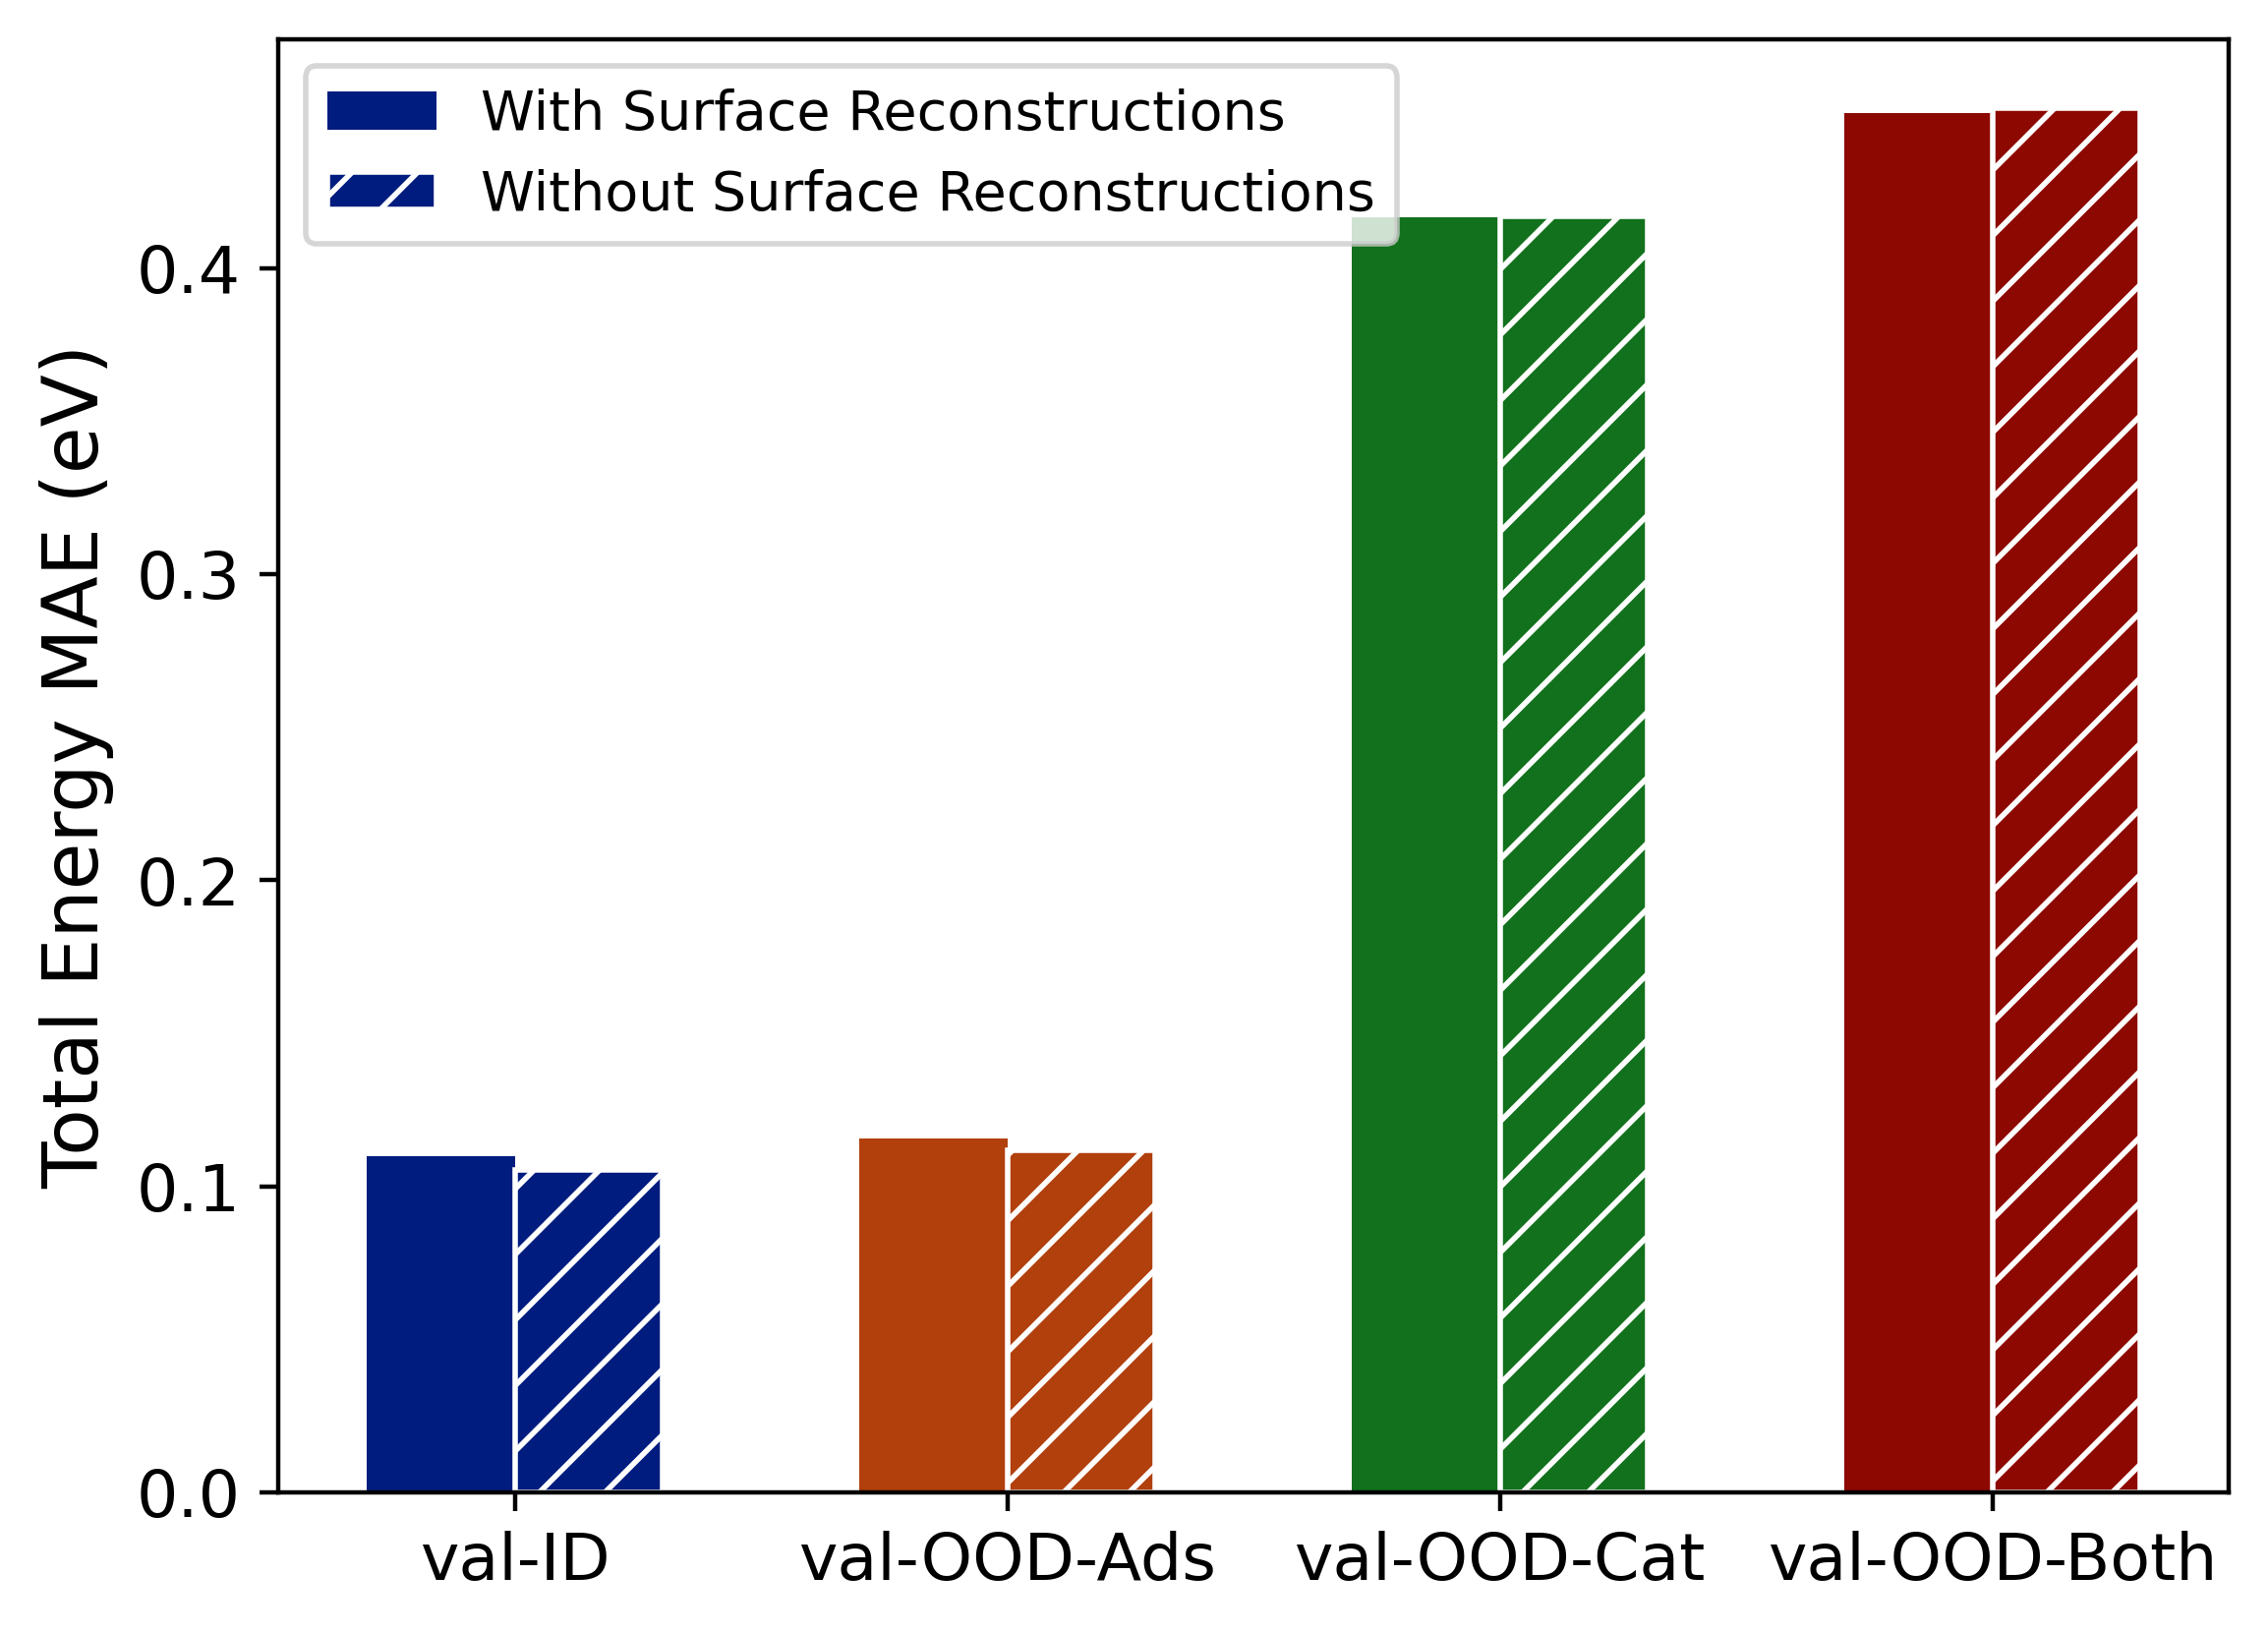

In [27]:
# Extract labels and mean values
# Define colors for different categories
colors = {"val-ID" : '#001c7f', "val-OOD-Ads": '#b1400d', "val-OOD-Cat": '#12711c', "val-OOD-Both": '#8c0800'}
materials = ["val-ID", "val-OOD-Ads", "val-OOD-Cat", "val-OOD-Both"]
original_maes = [id_mae, ood_ads_mae, ood_cat_mae, ood_both_mae]
surf_anom_maes = [id_no_surf_anom_mae, ood_ads_no_surf_anom_mae, ood_cat_no_surf_anom_mae, ood_both_no_surf_anom_mae]
ads_anom_maes = [id_no_ads_anom_mae, ood_ads_no_ads_anom_mae, ood_cat_no_ads_anom_mae, ood_both_no_ads_anom_mae]
x = np.arange(len(materials))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(dpi=400)

# Plotting the bars
ax.bar(x - width/2, original_maes, width, label='With Surface Reconstructions', color = colors.values())
ax.bar(x+ width/2, surf_anom_maes, width, label='Without Surface Reconstructions', 
       color = colors.values(),edgecolor='white',hatch='//' )

# Add legend
ax.legend()
# Add labels and title
ax.set_ylabel("Total Energy MAE (eV)",fontsize=14)
ax.set_xticks([0,1,2,3])
ax.set_xticks([0,1,2,3], materials)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);